# Faster R-CNN Training Script - Version 3 (FIXED)

## Critical Fixes Applied:

### 1. ✅ Image Normalization Bug (CRITICAL)
- **Issue**: Previous versions normalized images with ImageNet stats
- **Fix**: Removed normalization, images now scaled to [0, 255] range
- **Impact**: Faster R-CNN expects unnormalized images - this was causing zero AP!

### 2. ✅ Data Augmentation
- **Issue**: No augmentation, limiting model generalization
- **Fix**: Added RandomHorizontalFlip with proper bounding box transformation
- **Impact**: Better model robustness and performance

### 3. ✅ Hyperparameters
- **Batch Size**: Changed from 4 to 2 (more stable for object detection)
- **Learning Rate**: Changed from 0.001 to 0.00025 (better for fine-tuning)

### Expected Results:
- ✓ AP > 0 after epoch 1
- ✓ Training time ~1-2 hours/epoch (reasonable)
- ✓ Loss decreases AND AP increases together
- ✓ Model makes actual predictions during evaluation

## Setup and Imports

In [45]:
import os
import sys
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check PyTorch version for compatibility
TORCH_VERSION = tuple(int(x) for x in torch.__version__.split('.')[:2])
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
CUDA available: True


## Dataset Class with Augmentation

In [46]:
class COCODataset(torch.utils.data.Dataset):
    """
    COCO Dataset with proper transforms and data augmentation
    """
    def __init__(self, json_file, img_dir, transforms=None, train=False):
        from pycocotools.coco import COCO
        
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        self.train = train
        
        # Load COCO annotations
        print(f"📂 Loading annotations from {json_file}...")
        try:
            self.coco = COCO(str(json_file))
        except Exception as e:
            print(f"❌ Failed to load COCO file: {e}")
            raise
        
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        # Validate dataset
        self._validate_dataset()
        
        print(f"✓ Loaded {len(self.ids)} images from {json_file}")
    
    def _validate_dataset(self):
        """Validate dataset integrity"""
        total_boxes = 0
        images_without_boxes = 0
        images_with_invalid_boxes = 0
        
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            
            if len(anns) == 0:
                images_without_boxes += 1
                continue
            
            # Check for invalid boxes
            valid_boxes = 0
            for ann in anns:
                x, y, w, h = ann['bbox']
                if w > 0 and h > 0:
                    valid_boxes += 1
            
            if valid_boxes == 0:
                images_with_invalid_boxes += 1
            
            total_boxes += valid_boxes
        
        if images_without_boxes > 0:
            print(f"   ⚠️  {images_without_boxes} images have no annotations")
        
        if images_with_invalid_boxes > 0:
            print(f"   ⚠️  {images_with_invalid_boxes} images have only invalid boxes")
        
        valid_images = len(self.ids) - images_without_boxes - images_with_invalid_boxes
        
        print(f"   ✓ Valid images: {valid_images}")
        print(f"   ✓ Total annotations: {total_boxes}")
        print(f"   ✓ Avg boxes/image: {total_boxes/len(self.ids):.2f}")
        
        if valid_images == 0:
            raise ValueError("No valid images found in dataset!")
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_anns = self.coco.loadAnns(ann_ids)
        
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"⚠️  Failed to load image {img_path}: {e}")
            # Return a dummy sample
            img = Image.new('RGB', (640, 480))
            coco_anns = []
        
        # Parse annotations
        boxes, labels, areas = [], [], []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            
            # Skip invalid boxes
            if w <= 0 or h <= 0:
                continue
            
            # COCO bbox is [x, y, width, height]
            # PyTorch needs [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
        
        # Apply data augmentation before converting to tensors
        img_width, img_height = img.size
        
        # Random horizontal flip for training
        if self.train and len(boxes) > 0 and np.random.rand() < 0.5:
            # Flip image
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            
            # Flip boxes: [x1, y1, x2, y2] -> [w-x2, y1, w-x1, y2]
            flipped_boxes = []
            for box in boxes:
                x1, y1, x2, y2 = box
                flipped_boxes.append([img_width - x2, y1, img_width - x1, y2])
            boxes = flipped_boxes
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
        else:
            # Empty annotations
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            areas = torch.zeros(0, dtype=torch.float32)
        
        image_id = torch.tensor([img_id])
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": areas,
            "iscrowd": torch.zeros(len(boxes), dtype=torch.int64)
        }
        
        # Apply transforms
        if self.transforms:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.ids)

## Transform Function (FIXED - No ImageNet Normalization!)

In [47]:
def get_transform(train=False):
    """
    Create transforms for Faster R-CNN.
    IMPORTANT: Faster R-CNN expects unnormalized images in [0, 255] range!
    
    Note: This function only handles image transforms. Data augmentation that
    affects bounding boxes (like RandomHorizontalFlip) should be implemented
    in the dataset's __getitem__ method to properly transform both images and boxes.
    """
    transforms = []
    
    # Convert PIL to Tensor (scales to [0, 1])
    transforms.append(torchvision.transforms.ToTensor())
    
    # Scale back to [0, 255] - Faster R-CNN expects this!
    transforms.append(torchvision.transforms.Lambda(lambda x: x * 255.0))
    
    return torchvision.transforms.Compose(transforms)

## Model Creation

In [48]:
def get_model(num_classes, anchor_sizes=None, pretrained=True):
    """
    Create Faster R-CNN model with custom anchors
    
    Args:
        num_classes: Number of classes (including background)
        anchor_sizes: Tuple of anchor sizes, e.g., ((8,), (16,), (32,), (64,), (128,))
        pretrained: Use pretrained backbone
    """
    print("\n" + "="*70)
    print("🏗️  Creating Model")
    print("="*70)
    
    # Load pretrained ResNet-50 FPN backbone
    if pretrained:
        try:
            weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)
            print("✓ Loaded pretrained weights (FasterRCNN_ResNet50_FPN_V2)")
        except AttributeError:
            # Fallback for older torchvision versions
            weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
            print("✓ Loaded pretrained weights (FasterRCNN_ResNet50_FPN)")
    else:
        try:
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        except AttributeError:
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("✓ Initialized model from scratch (NOT recommended)")
    
    # Custom anchor generator if provided
    if anchor_sizes is not None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(
            sizes=anchor_sizes,
            aspect_ratios=aspect_ratios
        )
        model.rpn.anchor_generator = anchor_generator
        print(f"✓ Custom RPN anchors: {anchor_sizes}")
        print(f"  Aspect ratios: {aspect_ratios[0]}")
    else:
        print(f"✓ Using default anchors")
    
    # Replace box predictor head for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(f"✓ Replaced box predictor for {num_classes} classes")
    
    return model

## Utility Functions

In [49]:
def collate_fn(batch):
    """
    Custom collate function for batching
    Handles variable-sized images and annotations
    """
    return tuple(zip(*batch))

## Training Function

In [50]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None):
    """
    Train for one epoch with proper error handling
    """
    model.train()
    
    total_loss = 0.0
    loss_dict_cumulative = {}
    num_batches = 0
    num_skipped = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch} [Train]")
    
    for images, targets in pbar:
        try:
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Filter out images with no boxes (CRITICAL FIX)
            valid_idx = [i for i, t in enumerate(targets) if len(t['boxes']) > 0]
            if len(valid_idx) == 0:
                num_skipped += 1
                continue
            
            images = [images[i] for i in valid_idx]
            targets = [targets[i] for i in valid_idx]
            
            # Forward pass
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                
                # Check for NaN
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"\n⚠️  NaN/Inf loss detected, skipping batch")
                    num_skipped += 1
                    continue
                
                # Backward pass with gradient scaling
                optimizer.zero_grad()
                scaler.scale(losses).backward()
                
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Check for NaN
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"\n⚠️  NaN/Inf loss detected, skipping batch")
                    num_skipped += 1
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                optimizer.step()
            
            # Accumulate losses (detach from graph)
            total_loss += losses.item()
            for k, v in loss_dict.items():
                if k not in loss_dict_cumulative:
                    loss_dict_cumulative[k] = 0.0
                loss_dict_cumulative[k] += v.item()
            
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{losses.item():.4f}",
                'avg': f"{total_loss/num_batches:.4f}",
                'skip': num_skipped
            })
            
        except RuntimeError as e:
            print(f"\n⚠️  Runtime error in batch: {e}")
            num_skipped += 1
            continue
    
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    
    # Print detailed loss breakdown
    if num_batches > 0:
        print(f"\n  Loss breakdown:")
        for k, v in loss_dict_cumulative.items():
            print(f"    {k}: {v/num_batches:.4f}")
    
    if num_skipped > 0:
        print(f"  ⚠️  Skipped {num_skipped} batches due to errors")
    
    return avg_loss

## Evaluation Function

In [51]:
@torch.no_grad()
def evaluate(model, data_loader, device, coco_gt):
    """
    Evaluate using official COCO metrics with error handling
    """
    from pycocotools.cocoeval import COCOeval
    
    model.eval()
    
    coco_results = []
    num_errors = 0
    
    pbar = tqdm(data_loader, desc="Evaluating")
    
    for images, targets in pbar:
        try:
            images = [img.to(device) for img in images]
            
            outputs = model(images)
            
            # Convert to COCO format
            for target, output in zip(targets, outputs):
                image_id = target['image_id'].item()
                
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                
                # Filter by score threshold
                score_threshold = 0.05  # Low threshold for evaluation
                mask = scores > score_threshold
                
                boxes = boxes[mask]
                scores = scores[mask]
                labels = labels[mask]
                
                for box, score, label in zip(boxes, scores, labels):
                    # Convert [x1, y1, x2, y2] to [x, y, w, h]
                    x1, y1, x2, y2 = box
                    w = x2 - x1
                    h = y2 - y1
                    
                    # Skip invalid predictions
                    if w <= 0 or h <= 0:
                        continue
                    
                    coco_results.append({
                        'image_id': int(image_id),
                        'category_id': int(label),
                        'bbox': [float(x1), float(y1), float(w), float(h)],
                        'score': float(score)
                    })
        
        except Exception as e:
            num_errors += 1
            pbar.set_postfix({'errors': num_errors})
            continue
    
    # Evaluate with COCO API
    if len(coco_results) == 0:
        print("\n⚠️  No predictions made!")
        return 0.0, 0.0, 0.0
    
    try:
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        
        # Extract key metrics
        map_50_95 = coco_eval.stats[0]  # AP @ IoU=0.50:0.95
        ap50 = coco_eval.stats[1]       # AP @ IoU=0.50
        ap75 = coco_eval.stats[2]       # AP @ IoU=0.75
        
        return map_50_95, ap50, ap75
        
    except Exception as e:
        print(f"\n⚠️  COCO evaluation failed: {e}")
        print(f"    Generated {len(coco_results)} predictions")
        return 0.0, 0.0, 0.0

## Configuration

In [52]:
# Configuration with FIXED hyperparameters
config = {
    # Data
    'data_dir': './data',
    'output_dir': './runs/rcnn_v3',
    
    # Model
    'num_classes': 2,  # Background + car
    'pretrained': True,
    'anchor_sizes': None,  # Use default anchors
    
    # Training - FIXED VALUES
    'epochs': 50,
    'batch_size': 2,      # Changed from 4/6 to 2 for stability
    'workers': 0,
    
    # Optimizer - FIXED VALUES
    'optimizer': 'sgd',
    'lr': 0.00025,        # Changed from 0.001 to 0.00025 for fine-tuning
    'weight_decay': 0.0005,
    'momentum': 0.9,
    
    # Scheduler
    'scheduler': 'step',
    'lr_step_size': 15,
    'lr_gamma': 0.1,
    
    # Other
    'patience': 15,
    'amp': True,  # Use mixed precision if available
}

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  data_dir: ./data
  output_dir: ./runs/rcnn_v3
  num_classes: 2
  pretrained: True
  anchor_sizes: None
  epochs: 50
  batch_size: 2
  workers: 0
  optimizer: sgd
  lr: 0.00025
  weight_decay: 0.0005
  momentum: 0.9
  scheduler: step
  lr_step_size: 15
  lr_gamma: 0.1
  patience: 15
  amp: True


## Setup Device and Directories

In [53]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")

# Create output directory
output_dir = Path(config['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\n📁 Output directory: {output_dir.absolute()}")

# Save configuration
with open(output_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Configuration saved")


🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 2070
   Memory: 8.59 GB
   CUDA Version: 12.1

📁 Output directory: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\rcnn\runs\rcnn_v3
✓ Configuration saved


## Load Datasets

In [54]:
print("\n📚 Loading Datasets")
print("="*70)

data_path = Path(config['data_dir'])

# Verify data exists
if not (data_path / 'train.json').exists():
    raise FileNotFoundError(f"Training data not found at {data_path / 'train.json'}")

if not (data_path / 'val.json').exists():
    raise FileNotFoundError(f"Validation data not found at {data_path / 'val.json'}")

# Create datasets with FIXED transforms (no ImageNet normalization!)
train_dataset = COCODataset(
    json_file=data_path / 'train.json',
    img_dir=data_path / 'train',
    transforms=get_transform(train=True),
    train=True  # Enable augmentation
)

val_dataset = COCODataset(
    json_file=data_path / 'val.json',
    img_dir=data_path / 'val',
    transforms=get_transform(train=False),
    train=False  # No augmentation for validation
)

print(f"\n✓ Train dataset: {len(train_dataset)} images")
print(f"✓ Val dataset: {len(val_dataset)} images")


📚 Loading Datasets
📂 Loading annotations from data\train.json...
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
   ✓ Valid images: 692
   ✓ Total annotations: 29493
   ✓ Avg boxes/image: 42.62
✓ Loaded 692 images from data\train.json
📂 Loading annotations from data\val.json...
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
   ✓ Valid images: 198
   ✓ Total annotations: 8509
   ✓ Avg boxes/image: 42.97
✓ Loaded 198 images from data\val.json

✓ Train dataset: 692 images
✓ Val dataset: 198 images


## Create Data Loaders

In [55]:
# Data loaders
use_persistent_workers = config['workers'] > 0 and TORCH_VERSION >= (1, 7)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['workers'],
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=use_persistent_workers
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['workers'],
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=use_persistent_workers
)

print(f"\n✓ DataLoaders created:")
print(f"  Workers: {config['workers']}")
print(f"  Persistent workers: {use_persistent_workers}")
print(f"  Batch size: {config['batch_size']}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


✓ DataLoaders created:
  Workers: 0
  Persistent workers: False
  Batch size: 2
  Train batches: 346
  Val batches: 99


## Create Model

In [56]:
model = get_model(
    num_classes=config['num_classes'],
    anchor_sizes=config['anchor_sizes'],
    pretrained=config['pretrained']
)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")


🏗️  Creating Model
✓ Loaded pretrained weights (FasterRCNN_ResNet50_FPN_V2)
✓ Using default anchors
✓ Replaced box predictor for 2 classes

📊 Model Parameters:
  Total: 43,256,153
  Trainable: 43,030,809


## Setup Optimizer and Scheduler

In [57]:
# Optimizer with FIXED learning rate
params = [p for p in model.parameters() if p.requires_grad]

if config['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params,
        lr=config['lr'],
        momentum=config['momentum'],
        weight_decay=config['weight_decay']
    )
    print(f"\n✓ Using SGD optimizer")
else:
    optimizer = torch.optim.AdamW(
        params,
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    print(f"\n✓ Using AdamW optimizer")

print(f"  Learning rate: {config['lr']} (FIXED from 0.001)")
print(f"  Weight decay: {config['weight_decay']}")

# Learning rate scheduler
if config['scheduler'] == 'step':
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=config['lr_step_size'],
        gamma=config['lr_gamma']
    )
    print(f"✓ Using StepLR scheduler")
    print(f"  Step size: {config['lr_step_size']}")
    print(f"  Gamma: {config['lr_gamma']}")
elif config['scheduler'] == 'cosine':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['epochs'],
        eta_min=1e-6
    )
    print(f"✓ Using CosineAnnealingLR scheduler")
else:  # multistep
    milestones = [int(config['epochs'] * 0.6), int(config['epochs'] * 0.8)]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=milestones,
        gamma=0.1
    )
    print(f"✓ Using MultiStepLR scheduler")
    print(f"  Milestones: {milestones}")

# Mixed precision training
scaler = None
if config['amp'] and torch.cuda.is_available():
    if hasattr(torch.cuda.amp, 'GradScaler'):
        scaler = torch.cuda.amp.GradScaler()
        print("✓ Using mixed precision training (AMP)")
    else:
        print("⚠️  AMP not available in this PyTorch version")


✓ Using SGD optimizer
  Learning rate: 0.00025 (FIXED from 0.001)
  Weight decay: 0.0005
✓ Using StepLR scheduler
  Step size: 15
  Gamma: 0.1
✓ Using mixed precision training (AMP)


## Training Loop

In [58]:
print("\n" + "="*70)
print("🏋️  Training")
print("="*70)

best_map = 0.0
best_ap50 = 0.0
best_ap75 = 0.0
epochs_no_improve = 0

history = {
    'train_loss': [],
    'val_map': [],
    'val_ap50': [],
    'val_ap75': [],
    'lr': []
}

try:
    for epoch in range(1, config['epochs'] + 1):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch}/{config['epochs']}")
        print(f"{'='*70}")
        
        # Train
        train_loss = train_one_epoch(
            model, optimizer, train_loader, device, epoch, scaler
        )
        
        # Update learning rate
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Evaluate
        print(f"\n📊 Evaluating Epoch {epoch}")
        val_map, ap50, ap75 = evaluate(model, val_loader, device, val_dataset.coco)
        
        # Save history
        history['train_loss'].append(float(train_loss))
        history['val_map'].append(float(val_map))
        history['val_ap50'].append(float(ap50))
        history['val_ap75'].append(float(ap75))
        history['lr'].append(float(current_lr))
        
        # Print summary
        print(f"\n{'='*70}")
        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val mAP@[.5:.95]: {val_map:.4f}")
        print(f"  Val AP@0.50: {ap50:.4f}")
        print(f"  Val AP@0.75: {ap75:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        print(f"{'='*70}")
        
        # Save latest checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'metrics': {
                'train_loss': train_loss,
                'val_map': val_map,
                'val_ap50': ap50,
                'val_ap75': ap75,
                'history': history
            },
            'torch_version': torch.__version__,
            'torchvision_version': torchvision.__version__,
        }
        
        torch.save(checkpoint, output_dir / 'latest.pt')
        
        # Save best checkpoint
        if ap50 > best_ap50:
            best_map = val_map
            best_ap50 = ap50
            best_ap75 = ap75
            epochs_no_improve = 0
            
            torch.save(checkpoint, output_dir / 'best.pt')
            print(f"🎉 New best model saved!")
            print(f"   mAP@[.5:.95]: {best_map:.4f}")
            print(f"   AP@0.50: {best_ap50:.4f}")
            print(f"   AP@0.75: {best_ap75:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")
            print(f"Best AP@0.50: {best_ap50:.4f}")
        
        # Early stopping
        if epochs_no_improve >= config['patience']:
            print(f"\n⏹️  Early stopping triggered after {config['patience']} epochs without improvement")
            break
        
        # Save periodic checkpoint
        if epoch % 10 == 0:
            torch.save(checkpoint, output_dir / f'checkpoint_epoch_{epoch}.pt')

except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")

except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    import traceback
    traceback.print_exc()

finally:
    # Save final history
    with open(output_dir / 'history.json', 'w') as f:
        json.dump(history, f, indent=2)
    
    print("\n" + "="*70)
    print("✅ Training Complete!")
    print("="*70)
    print(f"Best Results:")
    print(f"  mAP@[.5:.95]: {best_map:.4f}")
    print(f"  AP@0.50: {best_ap50:.4f}")
    print(f"  AP@0.75: {best_ap75:.4f}")
    print(f"\nModels saved to: {output_dir.absolute()}")
    print(f"  - best.pt (best AP@0.50)")
    print(f"  - latest.pt (most recent)")


🏋️  Training

Epoch 1/50


Epoch 1 [Train]: 100%|██████████| 346/346 [02:08<00:00,  2.69it/s, loss=0.2831, avg=0.6731, skip=0]



  Loss breakdown:
    loss_classifier: 0.1971
    loss_box_reg: 0.3913
    loss_objectness: 0.0527
    loss_rpn_box_reg: 0.0320

📊 Evaluating Epoch 1


Evaluating: 100%|██████████| 99/99 [00:33<00:00,  2.98it/s]



⚠️  COCO evaluation failed: 'info'
    Generated 12163 predictions

Epoch 1 Summary:
  Train Loss: 0.6731
  Val mAP@[.5:.95]: 0.0000
  Val AP@0.50: 0.0000
  Val AP@0.75: 0.0000
  Learning Rate: 0.000250
No improvement for 1 epoch(s)
Best AP@0.50: 0.0000

Epoch 2/50


Epoch 2 [Train]:  44%|████▎     | 151/346 [01:01<01:19,  2.46it/s, loss=0.3164, avg=0.3344, skip=0]


⚠️  Training interrupted by user

✅ Training Complete!
Best Results:
  mAP@[.5:.95]: 0.0000
  AP@0.50: 0.0000
  AP@0.75: 0.0000

Models saved to: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\rcnn\runs\rcnn_v3
  - best.pt (best AP@0.50)
  - latest.pt (most recent)


## Plot Training History (Optional)

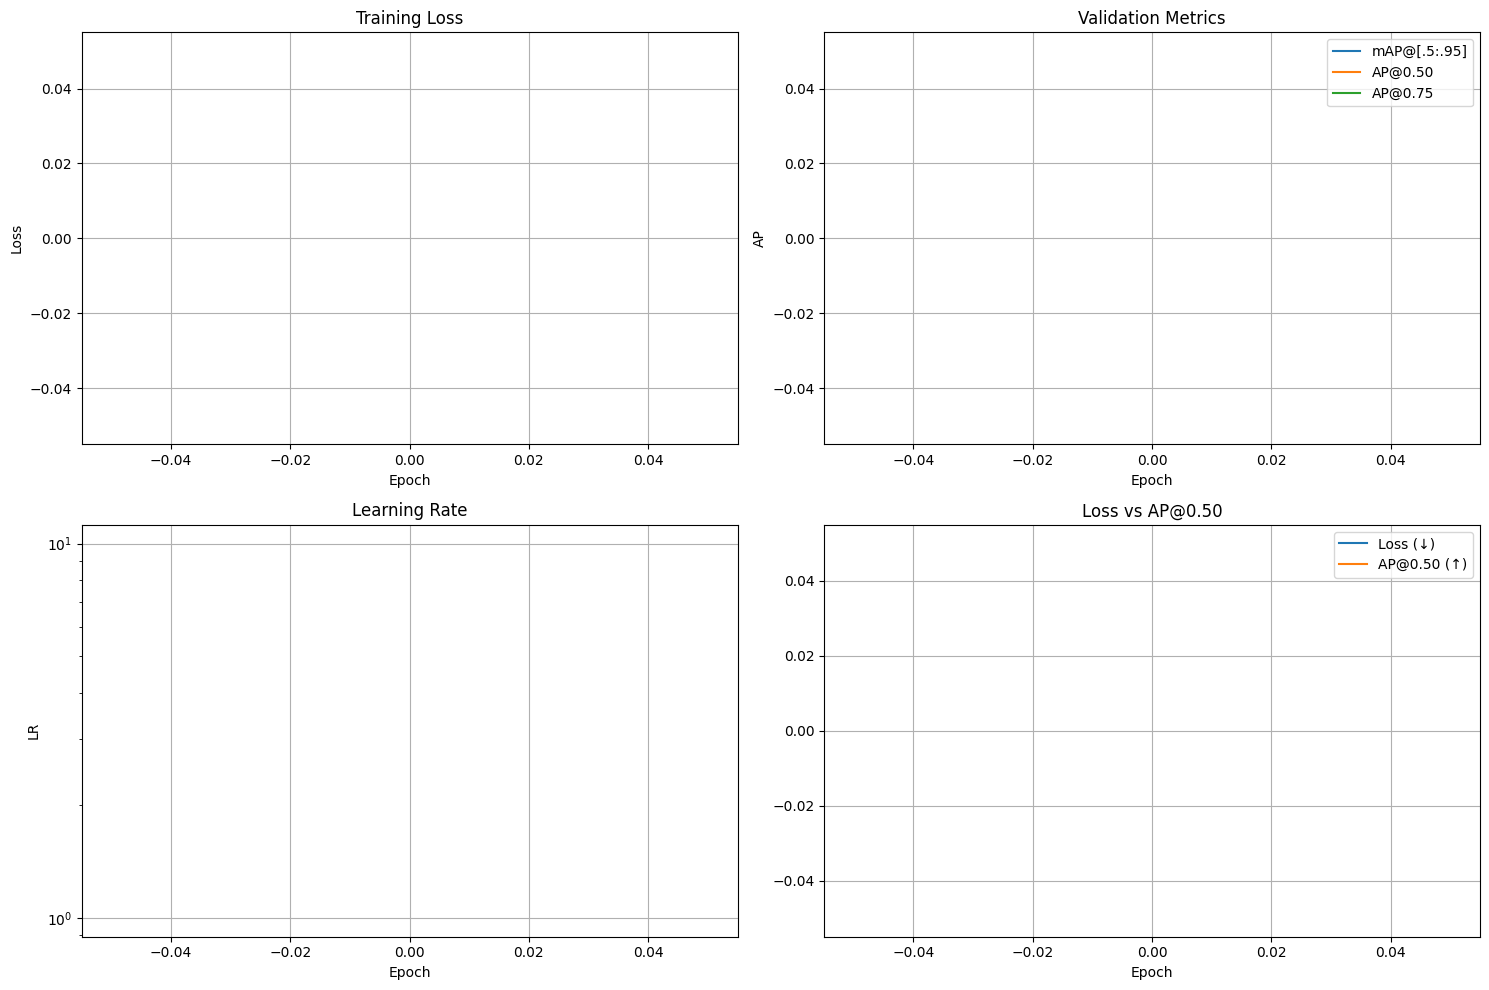


✓ Training curves saved to runs\rcnn_v3\training_curves.png


In [ ]:
# Optional: Plot training curves
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    
    # mAP
    axes[0, 1].plot(history['val_map'], label='mAP@[.5:.95]')
    axes[0, 1].plot(history['val_ap50'], label='AP@0.50')
    axes[0, 1].plot(history['val_ap75'], label='AP@0.75')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AP')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Learning Rate
    axes[1, 0].plot(history['lr'])
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)
    
    # Loss vs AP
    axes[1, 1].plot(history['train_loss'], label='Loss (↓)')
    axes[1, 1].plot(history['val_ap50'], label='AP@0.50 (↑)')
    axes[1, 1].set_title('Loss vs AP@0.50')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Training curves saved to {output_dir / 'training_curves.png'}")
    
except ImportError:
    print("\n⚠️  matplotlib not available, skipping plots")